<a href="https://colab.research.google.com/github/MarcosRMG/Estatisticas-de-Futebol/blob/main/Estatisticas_do_Futebol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Bibliotecas

In [33]:
# Leitura e tratamento dos dados
import pandas as pd
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np

# Autocorrelação
from statsmodels.graphics.tsaplots import plot_acf

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [34]:
# Personaliza visualizações
matplotlib.rcParams['font.size'] = 12
sns.set_style(style='darkgrid')

# 2 Variáveis

In [35]:
colunas_2 = {
    'Data': 'data', 
    'Horário': 'horario', 
    'Rodada': 'rodada', 
    'Dia': 'dia', 
    'Local': 'local', 
    'Resultado': 'resultado', 
    'GP': 'gols_marcados', 
    'GC': 'gols_sofridos',
    'Oponente': 'oponente', 
    'xG': 'xg', 
    'xGA': 'xga', 
    'Posse': 'posse', 
    'Público': 'publico', 
    'Capitão': 'capitao', 
    'Formação': 'formacao',
    'Árbitro': 'arbitro', 
    'Relatório da Partida': 'relatorio_partida', 
    'Notas': 'notas'
}

In [36]:
colunas = {
    'Cl': 'posicao',
    'Equipe': 'equipe',
    'MP': 'jogos',	
    'V': 'vitorias',	
    'E': 'empates',	
    'D': 'derrotas',	
    'GP': 'gols_marcados',	
    'GC': 'gols_sofridos',	
    'GD': 'saldo_gols',	
    'Pt': 'pontos',	
    'Últimos 5': 'ultimos_5'
}

# 3 Funções

## 3.1 Leitura e limpeza do html

In [37]:
def leitura_limpeza_html(url):
  '''
  Retira os espaços e o /n do documento html

  Keywords arguments
  url: Endereço url da página

  return: Documento html tratado
  '''
  response = urlopen(url)
  html = response.read().decode('UTF-8')
  html_limpo = ' '.join(html.split()).replace('> <', '><')
  html_soup = BeautifulSoup(html_limpo, 'html.parser')
  return html_soup

## 3.2 Trata tabela de rodadas da liga

In [38]:
def trata_tabela_rodadas_liga(html: str, dicionario_colunas=colunas_2, indice='rodada',
                      colunas_desconsideradas=['notas', 'publico', 
                                               'relatorio_partida', 'arbitro',
                                               'capitao', 'formacao', 'xga', 'xg',
                                               'horario', 'dia', 'data']):
  '''
  Trata a tabela da liga para análise

  Keywords arguments
  html: Variável que guarda o endereço html
  dicionario_colunas: Dicionário com a descrição da coluna padronizada
  indice: Indice da tabela
  colunas_desconsideradas: Lista de colunas que não serão analidas

  return: Nota tabela com as informações para análise
  '''
  # Cria a DataFrame
  rodadas = pd.read_html(html)[0]

  # Renomeia as colunas
  rodadas.rename(dicionario_colunas, axis=1, inplace=True)
  
  # Simplificando a informação de rodada
  rodadas[indice] = rodadas[indice].str[-2:]
  
  # Alterando o tipo  de dado da coluna rodada
  rodadas[indice] = rodadas[indice].astype('int32')
  
  # Definindo a coluna rodada como índice
  rodadas.set_index(indice, inplace=True)

  # Ordena pelo registro mais recente
  rodadas.sort_index(ascending=False, inplace=True)
  
  # Exclusão das colunas desnecessárias e linhas com NaN
  rodadas.drop(colunas_desconsideradas, axis=1, 
                              inplace=True)
  rodadas.dropna(inplace=True)

  return rodadas

## 3.3 Trata tabela da liga

In [39]:
def trata_tabela_liga(html: str, dicionario_colunas=colunas, 
                      colunas_desconsideradas=['xG', 'xGA', 'xGD', 'xGD/90', 
                                               'Público', 'Artilheiro da equipe', 
                                               'Goleiro', 'Notas']):
  '''
  Leitura e limpeza da tabela da liga

  Keywords arguments
  html: Html contendo as informações da tabela
  dicionario_colunas: Dicionário com a descrição da coluna padronizada
  colunas_desconsideradas: Lista de colunas que não serão analidas

  return: Nota tabela com as informações para análise
  '''
  tabela = pd.read_html(html)[0]
  tabela.rename(dicionario_colunas, axis=1, inplace=True)
  tabela.drop(colunas_desconsideradas, axis=1, inplace=True)
  return tabela

## 3.4 Calcula medidas de tendência central

In [40]:
def tendencia_central(dados: pd.DataFrame, time: str, numero_jogos=5, 
                      a_favor='gols_marcados', contra='gols_sofridos',
                      descricao_a_favor='Gols Marcados', 
                      descricao_contra='Gols Sofridos'):
  '''
  Mostra uma tabela com as estatísticas de gols

  Keywords argumensts
  dados: DataFrame com as informações para análise
  numero_jogos: Número de jogos anteriores a ser calculado, todo o histórico, 
  últimos 5, etc.
  time: Equipe de futebol que está sendo analisada
  a_favor: Coluna com as informações a favor do time
  contra: Coluna com as informações contra o time
  descricao_a_favor: Descrição da coluna com os número a favor do time
  descricao_contra: Descrição da coluna com os número contra o time

  return: Tabela com as estatísticas calculadas
  '''
  indice = f'''
  {time} - Últimos {numero_jogos} jogos
  '''
  _ =  pd.DataFrame({
      descricao_a_favor: [round(dados[a_favor][:numero_jogos].mean(), 1), 
                        round(dados[a_favor][:numero_jogos].median(), 1), 
                        round(dados[a_favor][:numero_jogos].mode()[0], 1),
                        round(dados[a_favor][:numero_jogos].std(), 1)],
      descricao_contra: [round(dados[contra][:numero_jogos].mean(), 1), 
                        round(dados[contra][:numero_jogos].median(), 1), 
                        round(dados[contra][:numero_jogos].mode()[0], 1),
                        round(dados[contra][:numero_jogos].std(), 1)],
      indice: ['Média', 'Mediana', 'Moda', 'Desvio Padrão']
  })
  _.set_index(indice, inplace=True)
  return _


## 3.5 Personaliza gráfico

In [41]:
def personaliza_grafico(titulo: str, eixo_x: str, eixo_y: str):
  plt.title(titulo, loc='left', fontsize=24, y=1.1)
  plt.xlabel(eixo_x, fontsize=14)
  plt.ylabel(eixo_y, fontsize=14);

## 3.6 Altera o tipo de dado

In [42]:
def altera_tipo_dado(dados: pd.DataFrame, coluna: str, tipo_dado: str):
  '''
  Altera o tipo de dado da coluna

  Keywords arguments
  dados: DataFrame contendo as informações
  coluna: Coluna do DataFrame para alteração do tipo de dado
  tipo_dado: Novo tipo de dado

  return: Coluna com o novo tipo de dado para atribuição ao DataFrame original
  '''
  return dados[coluna].astype(tipo_dado)

## 3.7 Altera formato da informação nas linhas

In [43]:
def altera_formato_informacao(dados: pd.DataFrame, coluna: str, 
                              dicionario_valores: dict()):
  '''
  Altera o tipo de dado da coluna

  Keywords arguments
  dados: DataFrame contendo as informações
  coluna: Coluna do DataFrame para alteração do tipo de dado
  dicionario_valores: Novos valores para as linhas

  return: Coluna com o novo formato de informação para coluna
  '''
  return dados[coluna].rename(dicionario_valores)

## 3.8 Binariza coluna

In [44]:
def binariza_coluna(dados: pd.DataFrame, colunas: list()):
  '''
  Realiza a binarização da coluna

  Keywords arguments
  dados: DataFrame com as informações para binarização
  colunas: Lista de colunas a ser binarizada

  return Dados binarizados para atribuição excluíndo se a coluna antiga
  '''
  dados = dados.join(pd.get_dummies(dados[colunas]))
  dados.drop(colunas, axis=1, inplace=True)
  dados.rename({'local_Visitante': 'visitante', 'local_Em casa': 'em_casa', 
                'resultado_E': 'empate', 'resultado_D': 'derrota', 
                'resultado_V': 'vitoria'}, axis=1, inplace=True)
  return dados

## 3.9 Calcula medidas de tendência central 2

In [45]:
def tendencia_central_2(dados: pd.DataFrame, time: str, numero_jogos=5, 
                      a_favor='gols_marcados', descricao_a_favor='Gols Marcados'):
  '''
  Mostra uma tabela com as estatísticas de gols

  Keywords argumensts
  dados: DataFrame com as informações para análise
  numero_jogos: Número de jogos anteriores a ser calculado, todo o histórico, 
  últimos 5, etc.
  time: Equipe de futebol que está sendo analisada
  a_favor: Coluna com as informações a favor do time
  descricao_a_favor: Descrição da coluna com os número a favor do time

  return: Tabela com as estatísticas calculadas
  '''
  indice = f'''
  {time} - Últimos {numero_jogos} jogos
  '''
  _ =  pd.DataFrame({
      descricao_a_favor: [round(dados[a_favor][:numero_jogos].mean(), 1), 
                        round(dados[a_favor][:numero_jogos].median(), 1), 
                        round(dados[a_favor][:numero_jogos].mode()[0], 1),
                        round(dados[a_favor][:numero_jogos].std(), 1)],
      indice: ['Média', 'Mediana', 'Moda', 'Desvio Padrão']
  })
  _.set_index(indice, inplace=True)
  return _


# 4 Serie A Italiana 2020-2021

## 4.1 Dados

In [46]:
# Tabela da Liga Italiana
fonte_liga_italiana_serie_a = 'https://fbref.com/pt/comps/11/Serie-A-Estatisticas#coverage'
tabela_liga_italiana_20_21 = trata_tabela_liga(fonte_liga_italiana_serie_a)

# Rodadas Inter de Milão
fonte_rodadas_inter_milao = 'https://fbref.com/pt/equipes/d609edc0/2020-2021/partidas/s10730/schedule/Internazionale-Resultados-e-Calendarios-Serie-A'
rodadas_inter_milao_liga = trata_tabela_rodadas_liga(fonte_rodadas_inter_milao)

# Rodadas Genoa
fonte_rodadas_genoa = 'https://fbref.com/pt/equipes/658bf2de/2020-2021/partidas/all_comps/schedule/Genoa-Resultados-e-Calendarios-Todos-os-campeonatos'
rodadas_genoa_liga = trata_tabela_rodadas_liga(fonte_rodadas_genoa)

ValueError: invalid literal for int() with base 10: 'da'

In [15]:
'''
Número de rodadas
'''
n_rodadas = rodadas_inter_milao_liga.shape[0]

### 4.1.1 Inter de Milão

In [16]:
# Binarizando e renomeando colunas
rodadas_inter_milao_liga =  binariza_coluna(rodadas_inter_milao_liga, ['resultado',
                                                                       'local'])

# 5 Análise de Dados

## 5.1 Tabela da liga

In [22]:
tabela_liga_italiana_20_21.head()

,posicao,equipe,jogos,vitorias,empates,derrotas,gols_marcados,gols_sofridos,saldo_gols,pontos,ultimos_5
0,1,Inter,23,16,5,2,57,24,33,53,D W W W W
1,2,Milan,23,15,4,4,45,28,17,49,L W W L L
2,3,Juventus,22,13,6,3,44,19,25,45,W W W L W
3,4,Roma,23,13,5,5,47,35,12,44,W W L W D
4,5,Atalanta,23,12,7,4,53,31,22,43,W L D W W


## 5.2 Tendência Central

In [58]:
tendencia_central(rodadas_inter_milao_liga, 'Inter de Milão', 
                  numero_jogos=n_rodadas)

,Gols Marcados,Gols Sofridos
Inter de Milão - Últimos 23 jogos,,
Média,2.5,1.0
Mediana,2.0,1.0
Moda,2.0,0.0
Desvio Padrão,1.4,0.9


In [59]:
tendencia_central_2(rodadas_inter_milao_liga.query('em_casa == 1'), 'Inter de Milão', 
                  a_favor='posse', descricao_a_favor='Posse de Bola - Casa',
                  numero_jogos=n_rodadas)

,Posse de Bola - Casa
Inter de Milão - Últimos 23 jogos,
Média,51.7
Mediana,50.0
Moda,35.0
Desvio Padrão,10.8


In [60]:
tendencia_central_2(rodadas_inter_milao_liga.query('visitante == 1'), 'Inter de Milão', 
                  a_favor='posse', descricao_a_favor='Posse de Bola - Fora',
                  numero_jogos=n_rodadas)

,Posse de Bola - Fora
Inter de Milão - Últimos 23 jogos,
Média,54.6
Mediana,59.0
Moda,60.0
Desvio Padrão,9.8


In [61]:
tendencia_central_2(rodadas_inter_milao_liga.query('visitante == 0'), 'Inter de Milão', 
                  a_favor='gols_marcados', descricao_a_favor='Gols Marcados - Casa',
                  numero_jogos=n_rodadas)

,Gols Marcados - Casa
Inter de Milão - Últimos 23 jogos,
Média,2.9
Mediana,3.0
Moda,2.0
Desvio Padrão,1.5


In [62]:
tendencia_central_2(rodadas_inter_milao_liga.query('visitante == 1'), 'Inter de Milão', 
                  a_favor='gols_marcados', descricao_a_favor='Gols Marcados - Fora',
                  numero_jogos=n_rodadas)

,Gols Marcados - Fora
Inter de Milão - Últimos 23 jogos,
Média,2.1
Mediana,2.0
Moda,2.0
Desvio Padrão,1.3


## 5.3 Correlação e Autocorrelação

Text(0.5, 1.0, 'Mapa de Correlação - Inter de Milão')

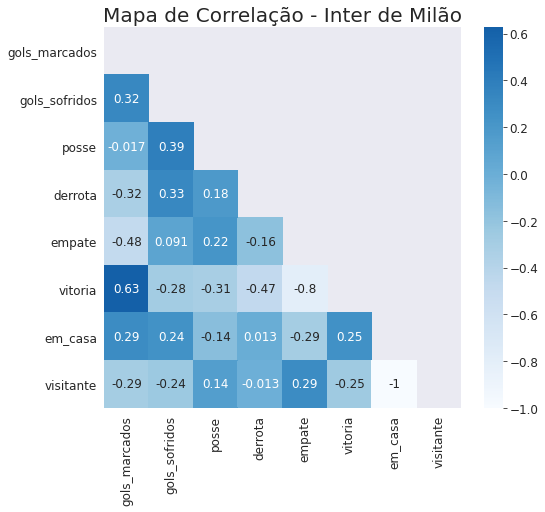

In [63]:
#Criar máscara para recortar o mapa de correlação
mask = np.zeros_like(rodadas_inter_milao_liga.corr())
mask[np.triu_indices_from(mask)] = True

# Plota o mapa de correlação
plt.figure(figsize=(8, 7))
sns.heatmap(rodadas_inter_milao_liga.corr(), cmap='Blues', annot=True, mask=mask,
            center=0)
plt.title('Mapa de Correlação - Inter de Milão', fontsize=20)

Correlação positiva: Gols marcados e vitórias

Não há correlação entre a posse de bola e o resultado da partida considerando todo o histórico

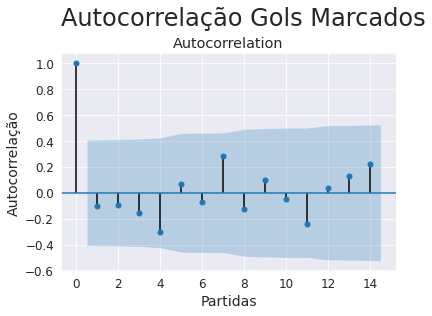

In [64]:
plot_acf(rodadas_inter_milao_liga['gols_marcados'])
personaliza_grafico('Autocorrelação Gols Marcados', 'Partidas', 'Autocorrelação')

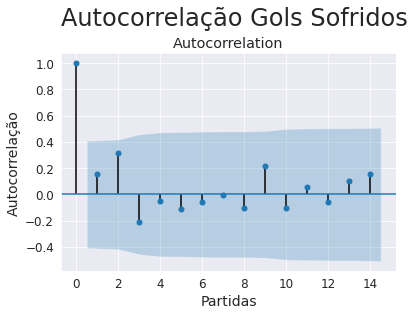

In [65]:
plot_acf(rodadas_inter_milao_liga['gols_sofridos'])
personaliza_grafico('Autocorrelação Gols Sofridos', 'Partidas', 'Autocorrelação')

O número de gols marcados e sofridos nas partidas anteriores não influencia na partidas seguintes.

# Gerando arquivo

In [31]:
rodadas_inter_milao_liga.to_csv('../dados/rodadas_inter_milao_liga.csv')

# Referências

FBREF. Estatísticas e Histórico do Futebol. Disponível em: https://fbref.com/pt/. Acesso em:  24 Fev. 2021.



---

